# AA with excluding/include AAs

In [18]:
def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

torch.cuda.empty_cache()
print_gpu_memory()

import gc

# Invoke garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

Allocated memory: 0.00 MB
Cached memory: 0.00 MB


In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

2025-01-13 12:35:52.289680: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 12:35:52.297276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 12:35:52.305776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 12:35:52.308244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 12:35:52.314869: I tensorflow/core/platform/cpu_feature_guar

## dataset

In [2]:
infile = '/home/yuan/results/epitope/epi_top_features.txt'
df = pd.read_csv(infile, sep='\t', header=0, index_col=None)
# balance the number of epitopes and non-epitopes
# shuffle rows
df = df.sample(frac=1)
df.head()

,seq,label,mean_hydro_ph7,mean_hydro,mean_polar,mean_polar_stab,mean_VDWV,median_hydro_ph7,median_hydro,median_polar,...,has_C,has_I,has_L,has_K,has_F,has_P,has_S,has_T,has_Y,has_V
2900486,DKANSWWLRHHPRV,1,17.071429,1.060714,8.900000,0.205929,4.325714,1.5,0.61,9.8,...,0,0,1,1,0,1,1,0,0,1
987835,IQCSDVVLH,0,37.222222,0.953333,7.833333,0.150778,3.268889,49.0,1.07,5.9,...,1,1,1,0,0,0,1,0,0,1
571955,KSEFEQNLSEKLSEQELQF,1,11.421053,0.710000,9.468421,0.167947,3.780000,-10.0,0.47,10.5,...,0,0,1,1,1,0,1,0,0,0
2991285,PSESRSGSN,0,-15.444444,0.372222,9.800000,0.106111,2.442222,-5.0,0.06,9.2,...,0,0,0,0,0,1,1,0,0,0
1271052,VECQHSGFG,0,20.777778,0.631111,8.555556,0.131222,2.812222,0.0,0.47,9.0,...,1,0,0,0,1,0,1,0,0,1


In [25]:
%load_ext autoreload
%autoreload 2

from seq.my_ann import MyAnn

## filter I: 
- Cys not in seq or Val in seq or Leu in seq

In [3]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) or 'V' in seq or 'L' in seq:
            return True
        return False
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
sub_df = sub_df.drop(['has_C', 'has_V', 'has_L'], axis=1)
print(sub_df.shape)

True     3434619
False      23619
Name: count, dtype: int64
(3434619, 47)


In [6]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X: (3434619, 45) float16
y: (3434619,) float16
labels: Counter({1.0: 1841623, 0.0: 1592996})
train data: (1923386, 45) (1923386,)
validate data: (824309, 45) (824309,)
test data (686924, 45) (686924,)


In [11]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 512)            │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,897 (284.75 KB)

 Trainable params: 72,897 (284.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 118s 2ms/step - accuracy: 0.6652 - auc: 0.7198 - loss: 0.6112 - mse: 0.2117 - precision: 0.6603 - recall: 0.7752 - val_accuracy: 0.6863 - val_auc: 0.7535 - val_loss: 0.5864 - val_mse: 0.2015 - val_precision: 0.6620 - val_recall: 0.8471
Epoch 2/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - accuracy: 0.6900 - auc: 0.7512 - loss: 0.5856 - mse: 0.2007 - precision: 0.6797 - recall: 0.7979 - val_accuracy: 0.7008 - val_auc: 0.7650 - val_loss: 0.5714 - val_mse: 0.1950 - val_precision: 0.6927 - val_recall: 0.7938
Epoch 3/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 92s 2ms/step - accuracy: 0.6957 - auc: 0.7581 - loss: 0.5795 - mse: 0.1981 - precision: 0.6854 - recall: 0.8005 - val_accuracy: 0.7049 - val_auc: 0.7685 - val_loss: 0.5682 - val_mse: 0.1936 - val_precision: 0.6976 - val_recall: 0.7931
Epoch 4/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.6976 - auc: 0.7608 - loss: 0.5772 - mse: 0.1971 - precision: 0.6871 - recall: 0.8003

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.673899,0.731650,0.601849,0.207741,0.666142,0.785936,0.686286,0.753471,0.586381,0.201491,0.661984,0.847132
1,0.691515,0.753020,0.584108,0.200049,0.681267,0.798432,0.700758,0.765002,0.571389,0.194953,0.692658,0.793805
2,0.696260,0.758840,0.578985,0.197834,0.685997,0.799843,0.704923,0.768464,0.568200,0.193562,0.697615,0.793148
3,0.698031,0.761446,0.576696,0.196847,0.688043,0.799543,0.699328,0.769512,0.573303,0.195685,0.671720,0.858453
4,0.699470,0.763206,0.575240,0.196183,0.690086,0.798165,0.704316,0.770892,0.569409,0.194055,0.684025,0.833028
5,0.700284,0.764251,0.574234,0.195774,0.691288,0.797274,0.706616,0.772247,0.564874,0.192220,0.694704,0.807286
6,0.701180,0.765169,0.573366,0.195402,0.692376,0.797018,0.705152,0.771872,0.566621,0.192972,0.687618,0.824224
7,0.701401,0.765858,0.572843,0.195152,0.692724,0.796717,0.706090,0.772955,0.565630,0.192516,0.688343,0.825116
8,0.701914,0.766378,0.572473,0.194959,0.693058,0.797441,0.696662,0.772852,0.575544,0.196634,0.664768,0.875382
9,0.702259,0.766714,0.572053,0.194808,0.693356,0.797708,0.705120,0.773198,0.566114,0.192791,0.683402,0.837891


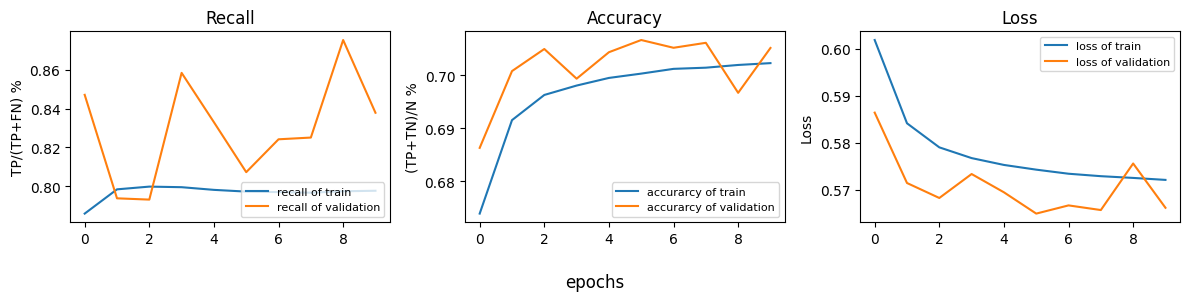

In [14]:
# evaluate model
c.plot_acc_recall()

21467/21467 ━━━━━━━━━━━━━━━━━━━━ 19s 880us/step - accuracy: 0.7059 - auc: 0.7742 - loss: 0.5654 - mse: 0.1924 - precision: 0.6844 - recall: 0.8379
{'accuracy': 0.7061479687690735, 'auc': 0.7742962837219238, 'loss': 0.5651864409446716, 'mse': 0.19235846400260925, 'precision': 0.6844185590744019, 'recall': 0.8383810520172119}
21467/21467 ━━━━━━━━━━━━━━━━━━━━ 7s 319us/step
[[0.43023816]
 [0.47503576]
 [0.7141193 ]]


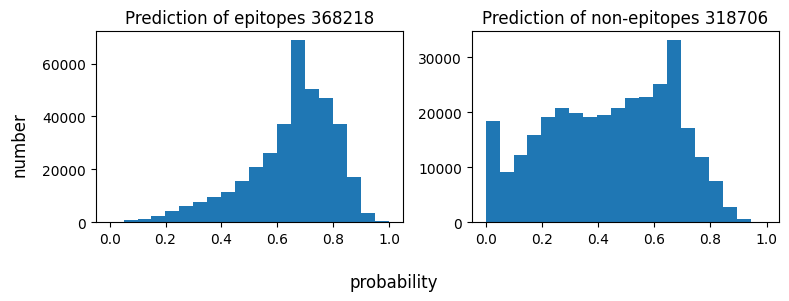

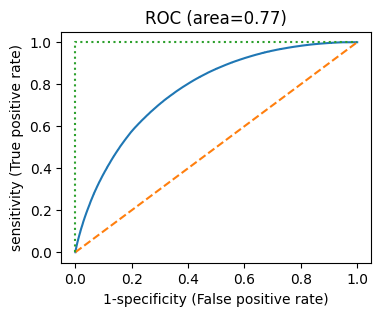

In [15]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [18]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_or_Val_or_Leu.keras')

<Sequential name=sequential_5, built=True>

In [19]:
# keep epitopes having Val or Leu, and without Cys
# not dropping
sub_df = df.loc[select]
print(sub_df.shape)

(3434619, 50)


In [20]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (3434619, 48) float16
y: (3434619,) float16
labels: Counter({1.0: 1841623, 0.0: 1592996})
train data: (1923386, 48) (1923386,)
validate data: (824309, 48) (824309,)
test data (686924, 48) (686924,)


In [21]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step - accuracy: 0.6680 - auc: 0.7241 - loss: 0.6070 - mse: 0.2101 - precision: 0.6615 - recall: 0.7796 - val_accuracy: 0.6937 - val_auc: 0.7570 - val_loss: 0.5783 - val_mse: 0.1981 - val_precision: 0.6769 - val_recall: 0.8195
Epoch 2/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 108s 2ms/step - accuracy: 0.6908 - auc: 0.7520 - loss: 0.5845 - mse: 0.2003 - precision: 0.6794 - recall: 0.8021 - val_accuracy: 0.7027 - val_auc: 0.7654 - val_loss: 0.5720 - val_mse: 0.1949 - val_precision: 0.6932 - val_recall: 0.7986
Epoch 3/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - accuracy: 0.6967 - auc: 0.7598 - loss: 0.5777 - mse: 0.1974 - precision: 0.6863 - recall: 0.8004 - val_accuracy: 0.7039 - val_auc: 0.7681 - val_loss: 0.5697 - val_mse: 0.1942 - val_precision: 0.6985 - val_recall: 0.7872
Epoch 4/10
60106/60106 ━━━━━━━━━━━━━━━━━━━━ 115s 2ms/step - accuracy: 0.6996 - auc: 0.7626 - loss: 0.5753 - mse: 0.1963 - precision: 0.6895 - recall: 0.800

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.675797,0.734315,0.598977,0.206684,0.666593,0.791420,0.693680,0.757015,0.578270,0.198085,0.676912,0.819540
1,0.693374,0.754931,0.582011,0.199218,0.682074,0.802327,0.702673,0.765406,0.572029,0.194867,0.693205,0.798595
2,0.697800,0.760691,0.576994,0.197038,0.687374,0.800824,0.703897,0.768098,0.569653,0.194195,0.698530,0.787165
3,0.699792,0.763188,0.574811,0.196074,0.689671,0.800524,0.706031,0.771459,0.565712,0.192535,0.699522,0.791344
4,0.700954,0.764980,0.573184,0.195379,0.691217,0.799747,0.705675,0.771584,0.565568,0.192568,0.691634,0.813423
5,0.701836,0.766114,0.572144,0.194934,0.692312,0.799412,0.706582,0.773671,0.563597,0.191818,0.687058,0.830918
6,0.702781,0.766988,0.571406,0.194601,0.693027,0.800437,0.706751,0.773862,0.564067,0.191980,0.688566,0.826658
7,0.703224,0.767415,0.571025,0.194421,0.693654,0.800043,0.705726,0.773228,0.566199,0.192791,0.684019,0.837936
8,0.703681,0.768041,0.570454,0.194174,0.694022,0.800476,0.708731,0.774732,0.565054,0.192078,0.707741,0.777546
9,0.703947,0.768552,0.569957,0.193953,0.693977,0.801493,0.707345,0.774721,0.563712,0.191761,0.687491,0.832134


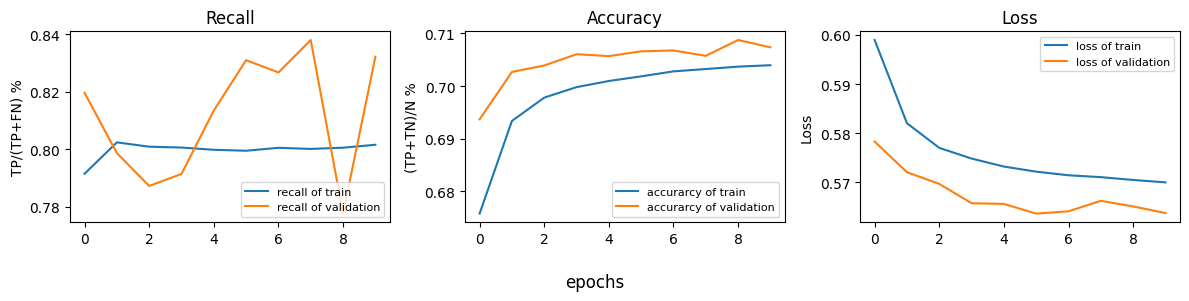

In [22]:
# evaluate model
c.plot_acc_recall()

21467/21467 ━━━━━━━━━━━━━━━━━━━━ 17s 771us/step - accuracy: 0.7082 - auc: 0.7759 - loss: 0.5629 - mse: 0.1914 - precision: 0.6886 - recall: 0.8322
{'accuracy': 0.7083069086074829, 'auc': 0.7758886814117432, 'loss': 0.5626378655433655, 'mse': 0.1913110762834549, 'precision': 0.6885815262794495, 'recall': 0.8322135210037231}
21467/21467 ━━━━━━━━━━━━━━━━━━━━ 7s 310us/step
[[0.23364815]
 [0.4752538 ]
 [0.71156263]]


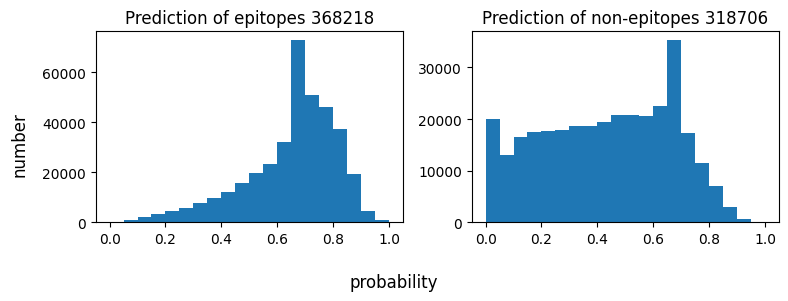

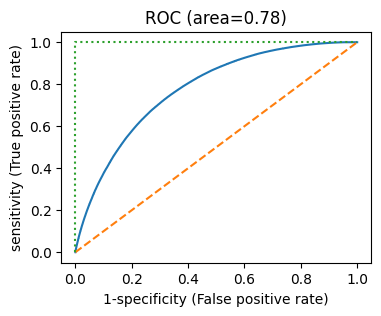

In [23]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [24]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_or_Val_or_Leu_nodropping.keras')

<Sequential name=sequential_6, built=True>

## filter II: 
- Cys not in seq and (Val in seq or Leu in seq)

In [25]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and ('V' in seq or 'L' in seq):
            return True
        return False
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
print(sub_df.shape)

True     3043115
False     415123
Name: count, dtype: int64
(3043115, 50)


In [26]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (3043115, 48) float16
y: (3043115,) float16
labels: Counter({0.0: 1592996, 1.0: 1450119})
train data: (1704144, 48) (1704144,)
validate data: (730348, 48) (730348,)
test data (608623, 48) (608623,)


In [27]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
53255/53255 ━━━━━━━━━━━━━━━━━━━━ 98s 2ms/step - accuracy: 0.7209 - auc: 0.8023 - loss: 0.5039 - mse: 0.1750 - precision: 0.6653 - recall: 0.8340 - val_accuracy: 0.7391 - val_auc: 0.8228 - val_loss: 0.4848 - val_mse: 0.1670 - val_precision: 0.6854 - val_recall: 0.8364
Epoch 2/10
53255/53255 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step - accuracy: 0.7363 - auc: 0.8203 - loss: 0.4883 - mse: 0.1683 - precision: 0.6813 - recall: 0.8398 - val_accuracy: 0.7467 - val_auc: 0.8300 - val_loss: 0.4783 - val_mse: 0.1640 - val_precision: 0.7057 - val_recall: 0.8033
Epoch 3/10
53255/53255 ━━━━━━━━━━━━━━━━━━━━ 108s 2ms/step - accuracy: 0.7406 - auc: 0.8249 - loss: 0.4845 - mse: 0.1666 - precision: 0.6883 - recall: 0.8327 - val_accuracy: 0.7495 - val_auc: 0.8326 - val_loss: 0.4775 - val_mse: 0.1636 - val_precision: 0.7026 - val_recall: 0.8223
Epoch 4/10
53255/53255 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - accuracy: 0.7435 - auc: 0.8281 - loss: 0.4812 - mse: 0.1651 - precision: 0.6924 - recall: 0.8306 -

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.727348,0.810029,0.497068,0.172194,0.670328,0.842247,0.739128,0.822768,0.484792,0.167027,0.685383,0.836434
1,0.737542,0.821727,0.487130,0.167778,0.683255,0.837795,0.746666,0.830002,0.478255,0.164006,0.705691,0.803325
2,0.741648,0.825849,0.483403,0.166092,0.689400,0.833582,0.749507,0.832563,0.477533,0.163572,0.702621,0.822289
3,0.743413,0.827716,0.481590,0.165293,0.692688,0.829918,0.747796,0.833440,0.476019,0.163126,0.689259,0.857061
4,0.744343,0.828870,0.480633,0.164832,0.694217,0.828690,0.751212,0.834886,0.473546,0.161908,0.707765,0.813895
5,0.744536,0.829399,0.480097,0.164609,0.694350,0.829006,0.748799,0.834309,0.474760,0.162612,0.688860,0.862217
6,0.745291,0.829924,0.479622,0.164382,0.695646,0.827866,0.751057,0.835427,0.472420,0.161547,0.698815,0.839207
7,0.745294,0.830441,0.479323,0.164196,0.696169,0.826290,0.749756,0.835796,0.474710,0.162514,0.688691,0.866444
8,0.745914,0.830628,0.479026,0.164100,0.696956,0.826221,0.752562,0.836695,0.472112,0.161223,0.706280,0.822884
9,0.746176,0.831066,0.478529,0.163915,0.697358,0.825985,0.750268,0.836312,0.472998,0.161764,0.691831,0.858084


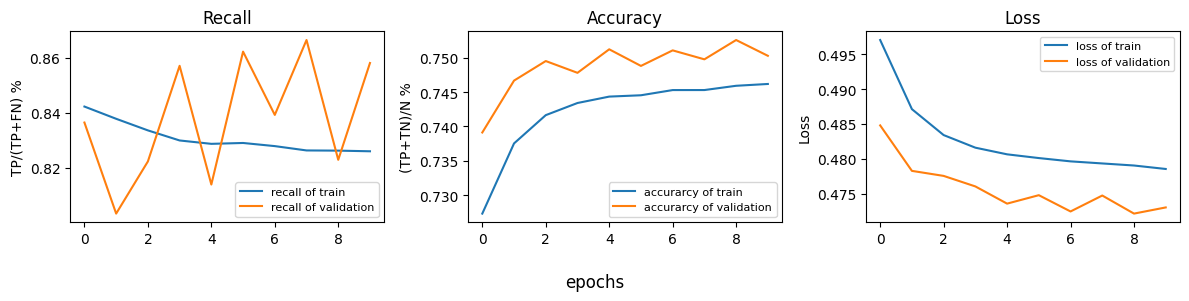

In [28]:
# evaluate model
c.plot_acc_recall()

19020/19020 ━━━━━━━━━━━━━━━━━━━━ 17s 875us/step - accuracy: 0.7492 - auc: 0.8369 - loss: 0.4725 - mse: 0.1616 - precision: 0.6905 - recall: 0.8563
{'accuracy': 0.7493324875831604, 'auc': 0.8363129496574402, 'loss': 0.4729243814945221, 'mse': 0.16178448498249054, 'precision': 0.6908978819847107, 'recall': 0.8569565415382385}
19020/19020 ━━━━━━━━━━━━━━━━━━━━ 6s 325us/step
[[0.5409716 ]
 [0.80781096]
 [0.67283005]]


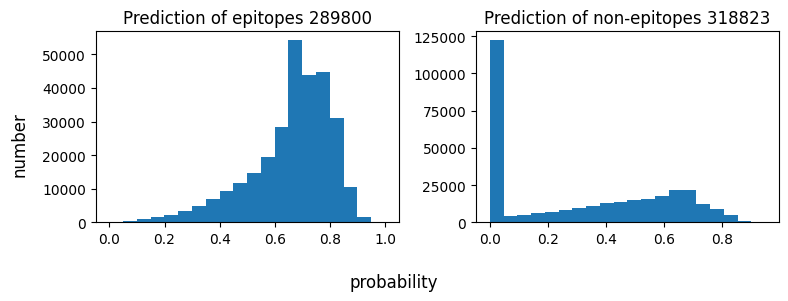

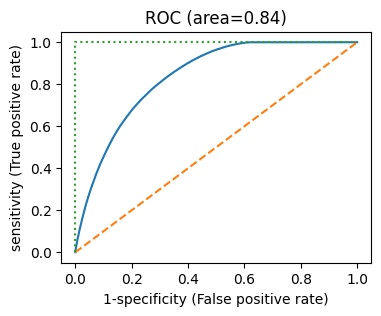

In [29]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [30]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_and_Val_or_Leu.keras')

<Sequential name=sequential_7, built=True>

## filter III: 
- Cys not in seq and and Val in seq and Leu in seq

In [31]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and 'V' in seq and 'L' in seq:
            return True
        return False
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes having Val or Leu, and without Cys
sub_df = df.loc[select]
print(sub_df.shape)

True     2263244
False    1194994
Name: count, dtype: int64
(2263244, 50)


In [32]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2263244, 48) float16
y: (2263244,) float16
labels: Counter({0.0: 1592996, 1.0: 670248})
train data: (1267416, 48) (1267416,)
validate data: (543179, 48) (543179,)
test data (452649, 48) (452649,)


In [33]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
39607/39607 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - accuracy: 0.8484 - auc: 0.9230 - loss: 0.2811 - mse: 0.0968 - precision: 0.6843 - recall: 0.9073 - val_accuracy: 0.8571 - val_auc: 0.9317 - val_loss: 0.2702 - val_mse: 0.0924 - val_precision: 0.6976 - val_recall: 0.9144
Epoch 2/10
39607/39607 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8563 - auc: 0.9303 - loss: 0.2713 - mse: 0.0929 - precision: 0.6983 - recall: 0.9062 - val_accuracy: 0.8583 - val_auc: 0.9327 - val_loss: 0.2684 - val_mse: 0.0918 - val_precision: 0.7009 - val_recall: 0.9109
Epoch 3/10
39607/39607 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step - accuracy: 0.8567 - auc: 0.9311 - loss: 0.2706 - mse: 0.0926 - precision: 0.6999 - recall: 0.9036 - val_accuracy: 0.8588 - val_auc: 0.9335 - val_loss: 0.2688 - val_mse: 0.0918 - val_precision: 0.7014 - val_recall: 0.9124
Epoch 4/10
39607/39607 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step - accuracy: 0.8568 - auc: 0.9313 - loss: 0.2707 - mse: 0.0926 - precision: 0.7009 - recall: 0.9019 - 

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.852515,0.926823,0.275414,0.094688,0.689910,0.912168,0.857080,0.931749,0.270237,0.092399,0.697641,0.914438
1,0.856286,0.930529,0.271191,0.092895,0.698650,0.905470,0.858266,0.932725,0.268424,0.091767,0.700875,0.910863
2,0.856997,0.931346,0.270285,0.092494,0.700796,0.902729,0.858826,0.933472,0.268784,0.091808,0.701402,0.912446
3,0.857569,0.931881,0.269756,0.092246,0.702318,0.901238,0.856353,0.932961,0.269567,0.092343,0.688640,0.941235
4,0.857952,0.932231,0.269326,0.092067,0.703516,0.899693,0.858130,0.934199,0.267549,0.091461,0.692705,0.937585
5,0.858424,0.932557,0.268937,0.091877,0.704512,0.899320,0.860832,0.934459,0.266082,0.090721,0.712217,0.890652
6,0.858681,0.932778,0.268663,0.091757,0.705295,0.898378,0.861600,0.934355,0.266027,0.090654,0.716285,0.883178
7,0.858757,0.932960,0.268554,0.091701,0.705610,0.897842,0.860368,0.934320,0.266441,0.090869,0.707192,0.903147
8,0.858666,0.933110,0.268324,0.091601,0.705794,0.896748,0.860887,0.934658,0.266249,0.090776,0.710230,0.896878
9,0.859276,0.933306,0.268039,0.091492,0.706764,0.897286,0.860869,0.934853,0.265796,0.090562,0.709712,0.898330


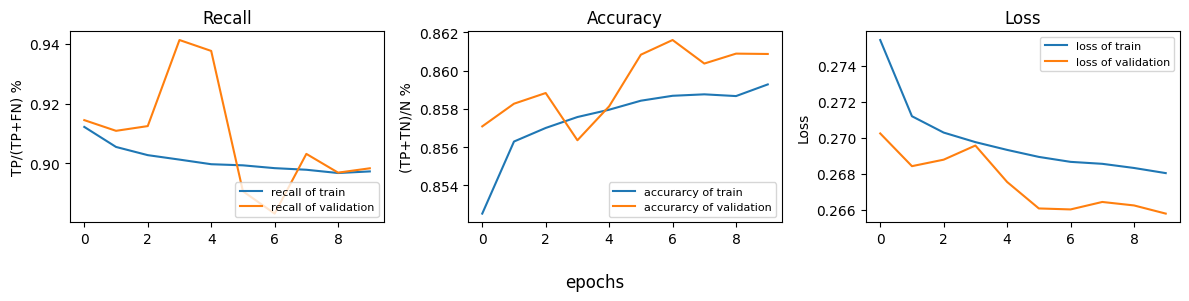

In [34]:
# evaluate model
c.plot_acc_recall()

14146/14146 ━━━━━━━━━━━━━━━━━━━━ 9s 618us/step - accuracy: 0.8615 - auc: 0.9354 - loss: 0.2648 - mse: 0.0901 - precision: 0.7086 - recall: 0.8997
{'accuracy': 0.8611948490142822, 'auc': 0.9350062608718872, 'loss': 0.26532885432243347, 'mse': 0.0903749018907547, 'precision': 0.708873987197876, 'recall': 0.8992294073104858}
14146/14146 ━━━━━━━━━━━━━━━━━━━━ 4s 290us/step
[[0.8620507 ]
 [0.        ]
 [0.73937225]]


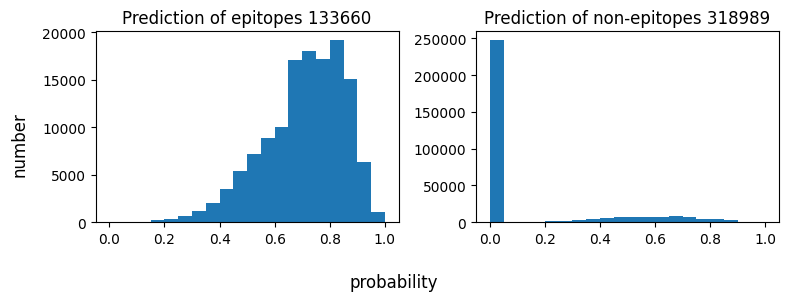

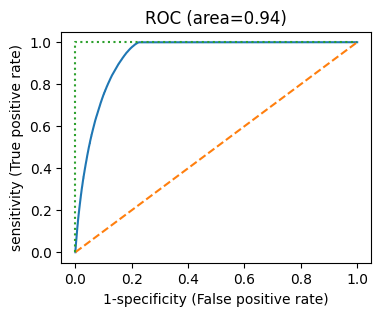

In [35]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [36]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_Val_Leu.keras')

<Sequential name=sequential_8, built=True>

### the other group

In [43]:
def fn(x):
    if x['label'] == 1:
        seq = str(x['seq'])
        if ('C' not in seq) and 'V' in seq and 'L' in seq:
            return False
        return True
    return True
select = df.apply(fn, axis=1)
print(select.value_counts())

# keep epitopes without Cys, Val or Leu
sub_df = df.loc[select]
print(sub_df.shape)

True     2787990
False     670248
Name: count, dtype: int64
(2787990, 50)


In [44]:
# prepare 
c = MyAnn()
c.get_xy(sub_df)

X: (2787990, 48) float16
y: (2787990,) float16
labels: Counter({0.0: 1592996, 1.0: 1194994})
train data: (1561274, 48) (1561274,)
validate data: (669118, 48) (669118,)
test data (557598, 48) (557598,)


In [45]:
# train model
c.declare_model()
c.train(epochs=10)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 512)            │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 96)             │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,433 (290.75 KB)

 Trainable params: 74,433 (290.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
48790/48790 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.7033 - auc: 0.7789 - loss: 0.5419 - mse: 0.1877 - precision: 0.6456 - recall: 0.6836 - val_accuracy: 0.7277 - val_auc: 0.8101 - val_loss: 0.5125 - val_mse: 0.1756 - val_precision: 0.6540 - val_recall: 0.7752
Epoch 2/10
48790/48790 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.7277 - auc: 0.8067 - loss: 0.5168 - mse: 0.1769 - precision: 0.6636 - recall: 0.7409 - val_accuracy: 0.7399 - val_auc: 0.8206 - val_loss: 0.5017 - val_mse: 0.1709 - val_precision: 0.6746 - val_recall: 0.7604
Epoch 3/10
48790/48790 ━━━━━━━━━━━━━━━━━━━━ 87s 2ms/step - accuracy: 0.7349 - auc: 0.8145 - loss: 0.5089 - mse: 0.1735 - precision: 0.6707 - recall: 0.7481 - val_accuracy: 0.7400 - val_auc: 0.8244 - val_loss: 0.4988 - val_mse: 0.1698 - val_precision: 0.6654 - val_recall: 0.7920
Epoch 4/10
48790/48790 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.7371 - auc: 0.8166 - loss: 0.5068 - mse: 0.1726 - precision: 0.6730 - recall: 0.7522 -

,accuracy,auc,loss,mse,precision,recall,val_accuracy,val_auc,val_loss,val_mse,val_precision,val_recall
0,0.712567,0.790326,0.531679,0.183495,0.652059,0.706645,0.727650,0.810100,0.512475,0.175601,0.653952,0.775229
1,0.729821,0.809079,0.514261,0.175856,0.665437,0.743767,0.739892,0.820584,0.501693,0.170915,0.674560,0.760399
2,0.735280,0.815160,0.508192,0.173210,0.671445,0.749117,0.740004,0.824399,0.498838,0.169787,0.665433,0.792020
3,0.737872,0.817474,0.505949,0.172195,0.674397,0.751362,0.744613,0.826237,0.494610,0.167979,0.683669,0.752935
4,0.739290,0.819166,0.504151,0.171438,0.676569,0.750847,0.745924,0.827165,0.493643,0.167558,0.685878,0.752029
5,0.739907,0.820427,0.502630,0.170827,0.677545,0.750543,0.745490,0.827612,0.493321,0.167293,0.680742,0.765702
6,0.740846,0.821014,0.502174,0.170580,0.678705,0.751102,0.744426,0.827685,0.497035,0.168782,0.673012,0.786006
7,0.741636,0.821769,0.501366,0.170234,0.679340,0.752635,0.747006,0.829337,0.491297,0.166512,0.685051,0.759148
8,0.741886,0.822204,0.500958,0.170061,0.679669,0.752726,0.747587,0.829458,0.491399,0.166625,0.686353,0.757771
9,0.741756,0.822378,0.500763,0.169970,0.679667,0.752160,0.747805,0.829816,0.490649,0.166272,0.682160,0.771431


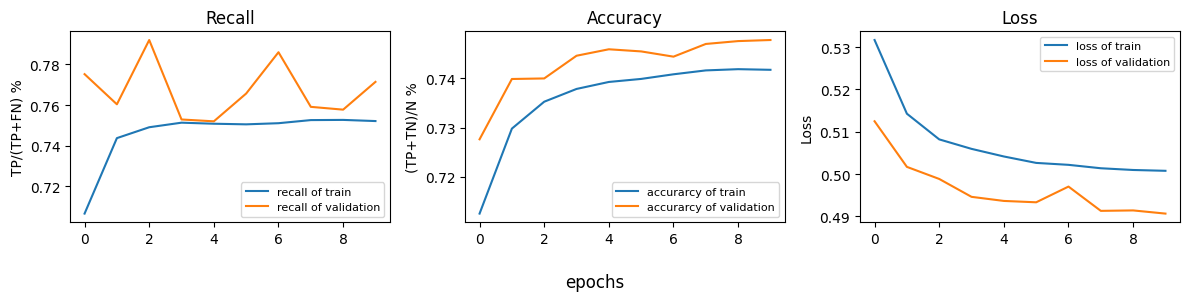

In [46]:
# evaluate model
c.plot_acc_recall()

17425/17425 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - accuracy: 0.7468 - auc: 0.8294 - loss: 0.4915 - mse: 0.1666 - precision: 0.6796 - recall: 0.7715
{'accuracy': 0.7464876174926758, 'auc': 0.8291444778442383, 'loss': 0.49145251512527466, 'mse': 0.16660860180854797, 'precision': 0.6798776388168335, 'recall': 0.7703844308853149}
17425/17425 ━━━━━━━━━━━━━━━━━━━━ 6s 320us/step
[[0.14578962]
 [0.57949954]
 [0.63210714]]


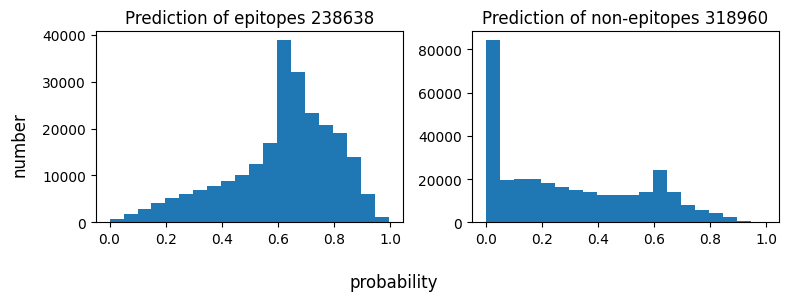

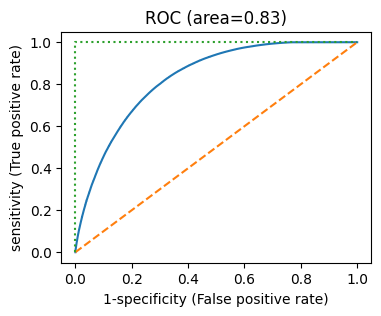

In [47]:
# evaluate model using test data
c.test()
c.plot_prob()
c.plot_roc()

In [49]:
# save entire model
c.save_model('../models/epitopes_ann_notCys_notVal_notLeu.keras')

<Sequential name=sequential_10, built=True>